In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


from sklearn import metrics, decomposition, preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

sns.set()
pd.options.display.max_columns = None
# We load our data and visualize the first 50 lines.
movies = pd.read_csv ("clean_data_films.csv")
movies.head(100)

,director_name,duration,genres,movie_title,plot_keywords,language,country,title_year,imdb_score,actors,age_limite
0,James Cameron,178.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,avatar|future|marine|native|paraplegic,English,USA,2009.000000,7.9,"['CCH Pounder', 'Joel David Moore', 'Wes Studi']",14
1,Gore Verbinski,169.0,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,goddess|marriage ceremony|marriage proposal|pi...,English,USA,2007.000000,7.1,"['Johnny Depp', 'Orlando Bloom', 'Jack Davenpo...",14
2,Sam Mendes,148.0,Action|Adventure|Thriller,Spectre,bomb|espionage|sequel|spy|terrorist,English,UK,2015.000000,6.8,"['Christoph Waltz', 'Rory Kinnear', 'Stephanie...",14
3,Christopher Nolan,164.0,Action|Thriller,The Dark Knight Rises,deception|imprisonment|lawlessness|police offi...,English,USA,2012.000000,8.5,"['Tom Hardy', 'Christian Bale', 'Joseph Gordon...",14
4,Doug Walker,0.0,Documentary,Star Wars: Episode VII - The Force Awakens ...,NaN,NaN,NaN,2002.470517,7.1,"['Doug Walker', 'Rob Walker', '']",17
...,...,...,...,...,...,...,...,...,...,...,...
95,James Gunn,121.0,Action|Adventure|Sci-Fi,Guardians of the Galaxy,bounty hunter|outer space|raccoon|talking anim...,English,USA,2014.000000,8.1,"['Bradley Cooper', 'Vin Diesel', 'Djimon Houns...",14
96,Christopher Nolan,169.0,Adventure|Drama|Sci-Fi,Interstellar,black hole|father daughter relationship|saving...,English,USA,2014.000000,8.6,"['Matthew McConaughey', 'Anne Hathaway', 'Mack...",14
97,Christopher Nolan,148.0,Action|Adventure|Sci-Fi|Thriller,Inception,ambiguous ending|corporate espionage|dream|sub...,English,USA,2010.000000,8.8,"['Leonardo DiCaprio', 'Tom Hardy', 'Joseph Gor...",14
98,Hideaki Anno,120.0,Action|Adventure|Drama|Horror|Sci-Fi,Godzilla Resurgence,blood|godzilla|monster|sequel,Japanese,Japan,2016.000000,8.2,"['Mark Chinnery', ""Shin'ya Tsukamoto"", 'Atsuko...",17


In [2]:
movies.columns

Index(['director_name', 'duration', 'genres', 'movie_title', 'plot_keywords',
       'language', 'country', 'title_year', 'imdb_score', 'actors',
       'age_limite'],
      dtype='object')

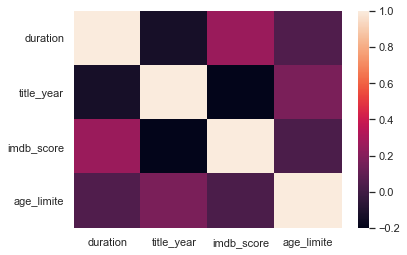

In [3]:
sns.heatmap(movies.corr())

### Supprimer les espaces et mise en minuscule

In [4]:
def minuscule_espace(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:       
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [5]:
# selection des colonnes qui fournissent des informations sur le contenu du film et qui nécessitent l'application de la fonction minuscule_espace
cols = ["plot_keywords", "genres", "age_limite","director_name"]

for element in cols:
    movies[element] = movies[element].apply(minuscule_espace)

In [55]:
movies['plot_keywords']

0                  avatar|future|marine|native|paraplegic
1       goddess|marriageceremony|marriageproposal|pira...
2                     bomb|espionage|sequel|spy|terrorist
3       deception|imprisonment|lawlessness|policeoffic...
4                                                        
                              ...                        
4912                fraud|postalworker|prison|theft|trial
4913           cult|fbi|hideout|prisonescape|serialkiller
4914                                                     
4915                                                     
4916    actressnameintitle|crush|date|fourwordtitle|vi...
Name: plot_keywords, Length: 4917, dtype: object

In [7]:
# toutes les valeurs nulles sont remplies par "" (espace)
for col in cols:
    movies[col]=movies[col].fillna(" ")

In [42]:
# nous combinons toutes les fonctionnalités uniques pour former un vecteur de colonne
def combined_features(row):
    return ' '.join(row['age_limite'].split('|')) + ' ' + ' ' .join(row['movie_title'].split('|')) + ' ' + row['genres'] + ' ' + row['plot_keywords']



In [43]:
movies['combined_features'] = movies.apply(combined_features, axis=1)

In [44]:
movies[['combined_features']]

,combined_features
0,Avatar action|adventure|fantasy|sci-fi avatar...
1,Pirates of the Caribbean: At World's End acti...
2,Spectre action|adventure|thriller bomb|espion...
3,The Dark Knight Rises action|thriller decepti...
4,Star Wars: Episode VII - The Force Awakens ...
...,...
4912,Signed Sealed Delivered comedy|drama fraud|po...
4913,The Following crime|drama|mystery...
4914,A Plague So Pleasant drama|horror|thriller
4915,Shanghai Calling comedy|drama|romance


In [45]:
#movies = movies [['movie_title', 'combined_features']]

In [46]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Recommandation par combined_features

Le modèle de recommandation ne peut lire et comparer un vecteur (matrice) qu'avec un autre, nous devons donc convertir le 'combined_features' en représentation vectorielle à l'aide de  CountVectorizer , qui est un simple compteur de fréquence pour chaque mot dans la colonne 'Bag_of_words'. Une fois que j'ai la matrice contenant le nombre de tous les mots, je peux appliquer la fonction cosine_similarity pour comparer les similitudes entre les films.

Il faut ensuite créer une série de titres de films, de sorte que l'index de la série puisse correspondre à l'index de ligne et de colonne de la matrice de similarité.

La dernière étape consiste à créer une fonction qui prend en entrée un titre de film et renvoie les 5 meilleurs films similaires. Cette fonction fera correspondre le titre du film d'entrée avec l'index correspondant de la matrice de similarité.

In [47]:
# Réinitialisons l'index de notre DataFrame principal et construisons le reverse mapping entre titles and index
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['movie_title'])

In [48]:
#Définissez un objet Vectorizer TF-IDF. Supprimez tous les mots vides anglais tels que «the», «a»
tfidf = TfidfVectorizer(stop_words='english')

#Remplacez NaN par une chaîne vide
movies['combined_features'] = movies['combined_features'].fillna('')

#Construire la matrice TF-IDF requise en ajustant et en transformant les données
tfidf_matrix = tfidf.fit_transform(movies['combined_features'])

#Sortie de la forme de tfidf_matrix
tfidf_matrix.shape


(4917, 11556)

In [49]:
cosine_sim2 = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [50]:
cosine_sim2

array([[1.        , 0.04323796, 0.03389455, ..., 0.        , 0.        ,
        0.        ],
       [0.04323796, 1.        , 0.0338393 , ..., 0.        , 0.        ,
        0.        ],
       [0.03389455, 0.0338393 , 1.        , ..., 0.02432395, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.02432395, ..., 1.        , 0.01870734,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01870734, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

## Film de Marine
####  RocknRolla, Inception, Hitch, Sherlock Holmes

In [51]:
# Voici la fonction qui prend un film en entrée et ressort les films les plus similaires
def get_recommendations(title, cosine_sim=cosine_sim2):
    # Obtenir l'index du film qui correspond au titre
    idx = indices[title]

    # Obtenez les scores de similarité pairwsie de tous les films avec ce film
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Trier les films en fonction des scores de similarité
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obtenez les scores des 5 films les plus similaires
    sim_scores = sim_scores[1:6]

    # Obtenir les index du film
    movie_indices = [i[0] for i in sim_scores]

    # Retourne le top 5 des films les plus similaires
    return movies['movie_title'].iloc[movie_indices]

### Générer des recommandations par titre, genres, mot clé, et age

In [58]:
filmo1 = input('Entrez le film que vous désirez voir :')
reco_data =pd.DataFrame(get_recommendations(filmo1, cosine_sim2))
reco_data

Entrez le film que vous désirez voir : Harry Potter and the Goblet of Fire


,movie_title
114,Harry Potter and the Order of the Phoenix
193,Harry Potter and the Prisoner of Azkaban
200,Harry Potter and the Sorcerer's Stone
203,Harry Potter and the Deathly Hallows: Part I
197,Harry Potter and the Deathly Hallows: Part II


# Recommandation par Genre

In [19]:
#Définissez un objet Vectorizer TF-IDF. Supprimez tous les mots vides anglais tels que «the», «a»
tfidf = TfidfVectorizer(stop_words='english')

#Remplacez NaN par une chaîne vide
movies['genres'] = movies['genres'].fillna('')

#Construire la matrice TF-IDF requise en ajustant et en transformant les données
tfidf_matrix = tfidf.fit_transform(movies['genres'])

#Sortie de la forme de tfidf_matrix
tfidf_matrix.shape

(4917, 29)

In [20]:
cosine_sim3 = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [21]:
# Voici la fonction qui prend un film en entrée et ressort les films les plus similaires
def get_recommendations_genres(title, cosine_sim=cosine_sim3):
    # Obtenir l'index du film qui correspond au titre
    idx = indices[title]

    # Obtenez les scores de similarité pairwsie de tous les films avec ce film
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Trier les films en fonction des scores de similarité
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obtenez les scores des 5 films les plus similaires
    sim_scores = sim_scores[1:6]

    # Obtenir les index du film
    movie_indices = [i[0] for i in sim_scores]

    # Retourne le top 5 des films les plus similaires
    return movies['movie_title'].iloc[movie_indices]

### Générer des recommandations 

In [57]:
filmo = input('Entrez le film que vous désirez voir :')
reco_data =pd.DataFrame(get_recommendations_genres(filmo, cosine_sim3))
reco_data

Entrez le film que vous désirez voir : Harry Potter and the Goblet of Fire


,movie_title
114,Harry Potter and the Order of the Phoenix
115,Harry Potter and the Goblet of Fire
193,Harry Potter and the Prisoner of Azkaban
282,Harry Potter and the Chamber of Secrets
1802,Return to Oz
